# EAS 4610 Final Project: Classic diffusive wave equation appriximated as the advection-diffusion PDE
### Manlin Xi, Kian Halim

## Introduction
Background and motivation: Flood events in recent times and resultant damages to infrastructure and control devices alike, demonstrate the importance of accurate modeling algorithms to simulate flood wave propagation. The solution to this problem requires constant correction and reduction of error accumulation in mathematical modeling and the respective formulas to describe as closely as possible the real scenery of such processes. The outcomes informed by such improvements to mathematical modeling in the simulation of flood wave propagation are characterized by increased community resiliency and preparedness of a given population. As the global effects from climate change become more significant with time, sea-level rise presents itself as a liability to coastal communities, subsurface infrastructure and many economies. Important steps toward advancements in public policy and approval of increased expenditures on control structures must be taken. Solution measures qualifying such proposals must be quantitatively robust and representative of as many scenarios as possible. For these reasons, models are constantly updated to uncover current vulnerabilities informed by sensitive dependence on conditional variance.

Comparison with past studies: As a long-standing issue, many other scientists and academic cohorts have prepared research and numerical models providing knowledge on the propagation of large floods. This knowledge has been built upon and shared to communities most at-risk, improving safety through predictability. Flood routing is called upon to define the time and magnitude of an event on a point of a waterway at one or more points upstream. The unsteadiness of this flow-relationship emphasizes the importance of improving equations through a variety of models.
For this 1-D hydraulic finite-difference model, one of the most used schemes to solve Saint-Venant equations is the Preissmann Scheme, also known as the four-point implicit method. Saint-Venant equations can also be simplified to be known as the Diffusive Wave Model. For the purposes of this project, the diffusive wave model will be solved using the Crank Nicolson method. Furthermore, this model can be solved by the QUICKEST or Muskingum-Cunge method. The Muskingum-Cunge method is considered a simpler approach and used internally by the Montana Dam Safety Program for flood routing calculations. This is one example of the utility provided by application of methods.


In [1]:
# import libraries
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.sparse import dia_matrix
#from sympy import *

## Methodology: equations and numerical model

For this problem, the conservation of mass and momentum along with the cross section of a channel is considered and ultimately define the main equations used within flood wave propagation studies in open channels. Using distance (x) and time (t) as variables within the functions, the following equations are used with terms given as such.

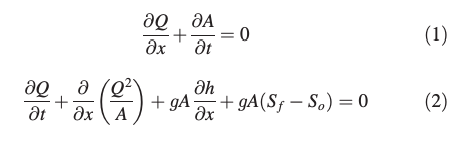

1. Q = discharge
2. A = cross-section area
3. h = flow depth
4. So = river bed slope
5. Sf = slope of energy grade line
6. g = gravitational acceleration

The equations here exist under the assumption that minor inputs are neglected such as：
Lateral inflow
1. Wind shear
2. Local losses from expansion/contraction
3. Other extraneous variables

The derivation of the Saint-Venant equations further assumes that：
1. Pressure is hydrostatic
2. Velocity is distributed evenly
3. Fluid is incompressible
4. The average bed slope is very small
5. Resistance coefficients for steady uniform flow are applicable

Equation 2 demonstrates the physical processes quantifying the flow momentum (momentum equation). For this reason, “∂Q/∂t” is the local acceleration term, describing the change in momentum with respect to time. Alternatively, (∂Q/∂t)*(Q2/A) is the convective acceleration term, describing the change in momentum resulting from a changing velocity downstream.

This said, all acceleration terms discussed above are only useful when considering the full dynamic wave equation. Under such scenarios, acceleration terms pertain to larger values when compared with the bed slope such as in the case of a breaching dam. These scenarios which use the dynamic wave show highly diffusive behavior, as with regions consisting of subcritical flows. 

It is for these reasons that flood wave propagation in channels consistent with subcritical flow (seemingly flat flow, no large local changes in surface height), can be simulated by the diffusive wave approximation equation. The diffusive wave approximation model will be used for this study, assuming acceleration terms to be negligible, reducing the momentum equation to the following.


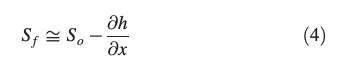

The reduced momentum equation is converted further into an advection-diffusion equation by the following.
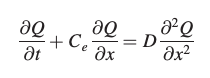

Both Ce (flood wave celerity) and D ( hydraulic diffusivity coefficient) are constants.

## Modeling construction

For this project we used the Crank-Nicolson (CN) numerical method to solve the advection-diffusion transport variant of the diffusive wave equation. The Crank-Nicolson method is a finite difference method used as a second-order method in time. The Crank-Nicolson implementation is shown below.

In [2]:
# set parameters & initialize grids (reach 1 chosen)
s0 = 0.0005
L = 74000 #m
width = 100 #m
t_tot = 72*60*60 #72 hrs, or 3 days

# initialize grids
dx = 250 #m
dt = 60 #s

# total time step and grid points we're running
m = int(L/dx) # number of spatial points, m
n = int(t_tot/dt) # number of time steps, n

# diffusivity coef
D = 2325 #m^2/s
# celerity
Ce = 1.19 #m/s

# Ca
Ca = Ce*(dt/dx)
# Cd
Cd = D*(dt/(dx**2))

In [3]:
# pre-allocate vectors 
Qi_k = np.zeros([m,1]) # all spatial solutions at time k (starting from initial)

Qall = np.zeros([m,n]) # collection of Q vectors, compilation of solutions at all timesteps

Ls = np.linspace(0,L,m) 
ts = np.linspace(0,t_tot,n) 

# print(Ls)
# print(ts)

In [4]:
# Create evolution matrix
# M1, M2
# approach: make a sparse matrix with diagonal elements
M1 = dia_matrix((m,m),dtype=np.double).toarray()
M2 = dia_matrix((m,m),dtype=np.double).toarray()

# 1.populate M1
# we want 1+Cd on the diagonal, (Ca/4 - Cd/2) along right subdiagonal, & -(Ca/4 + Cd/2) along left subdiagonal
for i in np.arange(0,m):
    for j in np.arange(0,m):
        if i==j: # we're on the diagonal
            M1[i,j] = 1+Cd
        elif i-1==j: # we're on the left sub-diagonal
            M1[i,j] = -(Ca/4 + Cd/2)
        elif i+1==j: # we're on the right sub-diagonal
            M1[i,j] = Ca/4 - Cd/2
#print(M1)

# 2.populate M2
# we want 1-Cd on the diagonal, -(Ca/4 - Cd/2) along right subdiagonal, & (Ca/4 + Cd/2) along left subdiagonal
for i in np.arange(0,m):
    for j in np.arange(0,m):
        if i==j: # we're on the diagonal
            M2[i,j] = 1-Cd
        elif i-1==j: # we're on the left sub-diagonal
            M2[i,j] = (Ca/4 + Cd/2)
        elif i+1==j: # we're on the right sub-diagonal
            M2[i,j] = -(Ca/4 - Cd/2)
#print(M2)

In [5]:
# initial condition
# a initial discharge 
Qi_k[0] = 465
Qi_k[1] = 465
Qall[:,0] = Qi_k.transpose()

In [6]:
# run model loop
# update Qi_k at each time step
for t in np.arange(1,n): # for every index going from 1 to the total number of timesteps
    #time = ts[t] # time is the corrsponding element in the ts vector
    # run matrix solve
    M1_inv = np.linalg.inv(M1)
    Qnew_pre = np.matmul(M1_inv,M2)
    Qnew = np.matmul(Qnew_pre,Qi_k)
    
    Qall[:,t] = Qnew.transpose()
    Qi_k = Qnew
    #print(Qi_k)

Crank-Nicolson was used to illustrate accuracy of finite-difference schemes within the context of flood wave propagation simulation. The goal under this scenario was to reduce approximation errors as much as possible as Δx and Δt approach 0.

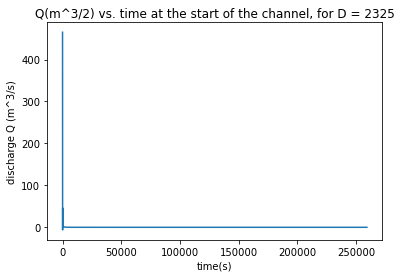

In [7]:
# plotting Q vs. time for the start of the channel (x=0)
plt.title('Q(m^3/2) vs. time at the start of the channel, for D = 2325');
plt.xlabel('time(s)');
plt.ylabel('discharge Q (m^3/s)');
plt.plot(ts,Qall[0]);

Results:
Shown above is the discharge (Q) at the first grid of the channel, or the start of the channel. Three days worth of timesteps are plotted on the x-axis, and discharge is the y-axis. As we can see, the discharge is shown as a sudden spike reaching the initial condition level: 465 m^3/s, while the rest of the timesteps remain at near 0 levels. This is comparative to literature values. 

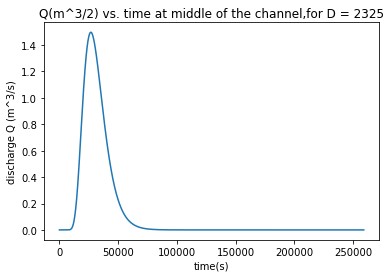

In [8]:
# plotting Q vs. time for the middle of the channel, x=37km
plt.title('Q(m^3/2) vs. time at middle of the channel,for D = 2325');
plt.xlabel('time(s)');
plt.ylabel('discharge Q (m^3/s)');
plt.plot(ts,Qall[148]);

The above shows the discharge vs. time at the middle of the channel (at 37km in a 74km-long channel).It is expected that the maximum discharge at this location will be much smaller than what is observed at the start of the channel due to the wave being advected and diffused as it propogates through the length of the channel. This is indeed what we observe. The maximum discharge Q observed here is ~1.5, peaking at a time of ~30000 seconds. 

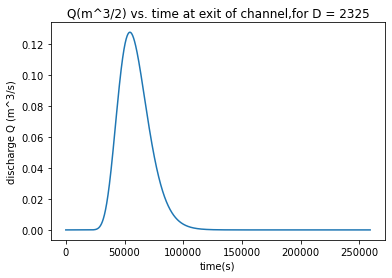

In [9]:
# plotting Q vs. time for the end of the channel (x=74km)
plt.title('Q(m^3/2) vs. time at exit of channel,for D = 2325');
plt.xlabel('time(s)');
plt.ylabel('discharge Q (m^3/s)');
plt.plot(ts,Qall[295]);

The third and last graph for diffusivity = 2325 describes the discharge vs. time pattern at the exit/end of the channel (at x=74km in a 74km-long channel). Similar to the middle-transect graph generated above, it is expected that the maximum discharge at this location will be much smaller than what is observed at the start of the channel due to the wave being advected and diffused as it propogates through the length of the channel. In addition, the maximum discharge should also be smaller than the maximum discharge observed at the middle of the channel. This is validated by what we observe. The maximum discharge Q observed here is close to 0.13, peaking at a time of ~60000 seconds.

## 2. Repeat the above process for a diffusivity that is half as before

It is of interest to see whether the maginitude of the diffusivity constant will change the wave's evolution through space in the channel. Therefore, we have set a diffusivity D value that is half as large as before. Before running the model, we predict that under this new D value, the maximum discharge values seen in the middle of the channel and at the end will be discernibly different than when D was twice as large. Specifically, we expect to see a slowed-down diffusion and larger magnitudes for maximum discharge at both locations compared to D = 2325.  

In [10]:
# diffusivity coef
D2 = 1162.5 #m^2/s
# celerity
Ce = 1.19 #m/s

# Ca
Ca2 = Ce*(dt/dx)
# Cd
Cd2 = D2*(dt/(dx**2))

In [11]:
# pre-allocate vectors 
Qi_k2= np.zeros([m,1]) # all spatial solutions at time k (starting from initial)

Qall2 = np.zeros([m,n]) # collection of Q vectors, compilation of solutions at all timesteps

Ls2 = np.linspace(0,L,m) 
ts2 = np.linspace(0,t_tot,n) 

In [12]:
# Create evolution matrix
# M3, M4
# approach: make a sparse matrix with diagonal elements
M3 = dia_matrix((m,m),dtype=np.double).toarray()
M4 = dia_matrix((m,m),dtype=np.double).toarray()

# 1.populate M3
# we want 1+Cd on the diagonal, (Ca/4 - Cd/2) along right subdiagonal, & -(Ca/4 + Cd/2) along left subdiagonal
for i in np.arange(0,m):
    for j in np.arange(0,m):
        if i==j: # we're on the diagonal
            M3[i,j] = 1+Cd2
        elif i-1==j: # we're on the left sub-diagonal
            M3[i,j] = -(Ca2/4 + Cd2/2)
        elif i+1==j: # we're on the right sub-diagonal
            M3[i,j] = Ca2/4 - Cd2/2
#print(M1)

# 2.populate M4
# we want 1-Cd on the diagonal, -(Ca/4 - Cd/2) along right subdiagonal, & (Ca/4 + Cd/2) along left subdiagonal
for i in np.arange(0,m):
    for j in np.arange(0,m):
        if i==j: # we're on the diagonal
            M4[i,j] = 1-Cd2
        elif i-1==j: # we're on the left sub-diagonal
            M4[i,j] = (Ca2/4 + Cd2/2)
        elif i+1==j: # we're on the right sub-diagonal
            M4[i,j] = -(Ca2/4 - Cd2/2)
#print(M2)

In [13]:
# initial condition
Qi_k2[0] = 465
Qi_k2[1] = 465
Qall2[:,0] = Qi_k2.transpose()

In [14]:
# run model loop
# update Qi_k at each time step
for t in np.arange(1,n): # for every index going from 1 to the total number of timesteps
    #time = ts[t] # time is the corrsponding element in the ts vector
    # run matrix solve
    M3_inv = np.linalg.inv(M3)
    Qnew_pre2 = np.matmul(M3_inv,M4)
    Qnew2 = np.matmul(Qnew_pre2,Qi_k2)
    
    Qall2[:,t] = Qnew2.transpose()
    Qi_k2 = Qnew2
    #print(Qi_k)

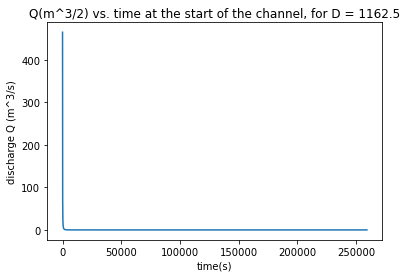

In [15]:
# plotting Q vs. time for the start of the channel (x=0)
plt.title('Q(m^3/2) vs. time at the start of the channel, for D = 1162.5');
plt.xlabel('time(s)');
plt.ylabel('discharge Q (m^3/s)');
plt.plot(ts2,Qall2[0]);

Result for D = 1162.5:
Shown above is the discharge (Q) at the first grid of the channel, or the start of the channel (x=0km in the 74km channel). The discharge here is not significantly diffferent from that for D = 2325. A sudden spike reaching the initial condition level 465 m^3/s is observed as before, while the rest of the timesteps remain at near 0 levels. Once again, this is comparative to literature values. This does not negate our hypothesis as we are focusing on the very first grid space and the effect of diffusivity takes place as the wave starts moving down the channel.

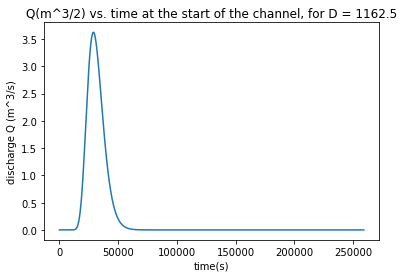

In [16]:
# plotting Q vs. time for the middle of the channel (x=37km)
plt.title('Q(m^3/2) vs. time at the start of the channel, for D = 1162.5');
plt.xlabel('time(s)');
plt.ylabel('discharge Q (m^3/s)');
plt.plot(ts2,Qall2[148]);

The above shows the discharge vs. time at the middle of the channel (at 37km in a 74km-long channel) for the new diffusivity value. The maximum discharge at this location is much smaller than what is observed at the start of the channel due to the wave being diffused, which is logically sound as reasoned previously. The maximum discharge Q observed here is ~3.5, peaking at a time of ~30000 seconds. This is 4 times the maximum discharge observed in the middle of the channel for D = 2325. This validates our perdiction that with smaller diffusivity, the wave will diffuse slower and remain at higher values at all locations in the channel compared to the higher D value.

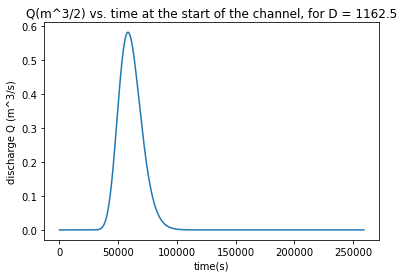

In [17]:
# plotting Q vs. time for the start of the channel (x=0)
plt.title('Q(m^3/2) vs. time at the start of the channel, for D = 1162.5');
plt.xlabel('time(s)');
plt.ylabel('discharge Q (m^3/s)');
plt.plot(ts2,Qall2[295]);

The above shows the discharge vs. time at the end of the channel (at 74km in the 74km-long channel) for the new diffusivity value. The maximum discharge at this location is both smaller than what is observed at the start of the channel and in the middle as one would expect. The maximum discharge Q observed here is ~0.6, peaking at a time of ~60000 seconds. In contrast, the maximum discharge for this location was ~0.12 under D = 2325 conditions. This once again validates our prediction that with smaller diffusivity, discharge levels would remain at higher values at all locations in the channel compared to the higher D value.

# Conclusions

The model implemented above utilizing the Crank-Nicolson method to simulate flood wave propogation confirmed previous observations regarding the relationship between the classical dynamic wave equation and the diffusive wave equation (variant of the advection-diffusion equation). The dynamic wave equations output in dam breaking scenarios implied highly diffusive behavior with consideration to all acceleration terms (local and convective). In the case of regions considering subcritical flow, the diffusive wave model was more appropriate.

As consistent with the derivation of the diffuive wave model (variant of advection-diffusion equation), the discharge measured over the length of the channel (74 km), exemplified high diffusivity with respect to time. This was confirmed with assigning a perturbation to the Diffusion coefficient, spiking in similar places however still consistent with highly diffusive behavior. Predictions regarding the magnitude of diffusivity were confirmed by the model's accuracy in showing a constrained discharge compared to equal points in space where a greater diffusivity coefficient was used.

This model could be improved by adding iterations of the simulation whereby different inital conditions were considered. For plotting purposes this would show visually more deviations and errors in our method, allowing it to be improved, or identify how other methods account for certain conditions better. This type of deviation from the current model has potential to highlight the importance of sensitive dependence on initial conditions. The more variance considered from the point of initialization, the less fragile the model becomes. The model may also be re-written to consider timeframes and river channels that are smaller or larger, converging on schemes that work well for each. The ability to alter these variables (time and channel length) would vary depending on the geographical regions and populations concerned. As with other problems in Earth Science, certain numerical methods are better suited depending on the system being modeled.

This model could also finally be improved if we were to consider a scenario whereby local and convective acceleration terms are more significant. Under such parameters, the full dynamic equation can be fully taken advantage of, perhaps providing different results.

This type of study has great utility within conversations considering urban planning, and climate resiliency planning. Full disclsure of vulnerabilities to populations and infrastructure requires quantititaive analysis of control systems already in place. Lastly, the model could be hypothesized to include chemical species that alter rates of diffusion based on their composition (polarity, salinity, etc.). Appending such terms to the equations modeled gives way for information to be obtained that may be useful in predicting thresholds for susbsurface infrastructure integrity and corrosivity.

# References

https://www.engr.colostate.edu/~pierre/ce_old/Projects/Paperspdf/Palu-Julien%20ASCE%20JHE%202020.pdf
http://hydrologydays.colostate.edu/Abstracts_05/Raimundo_abs_3.pdf
https://www.sciencedirect.com/topics/earth-and-planetary-sciences/subcritical-flow
https://www.youtube.com/watch?v=FHLCbNClRFY&t=410s

Ponce, V. M. 2014. Engineering hydrology. London: Macmillan Education

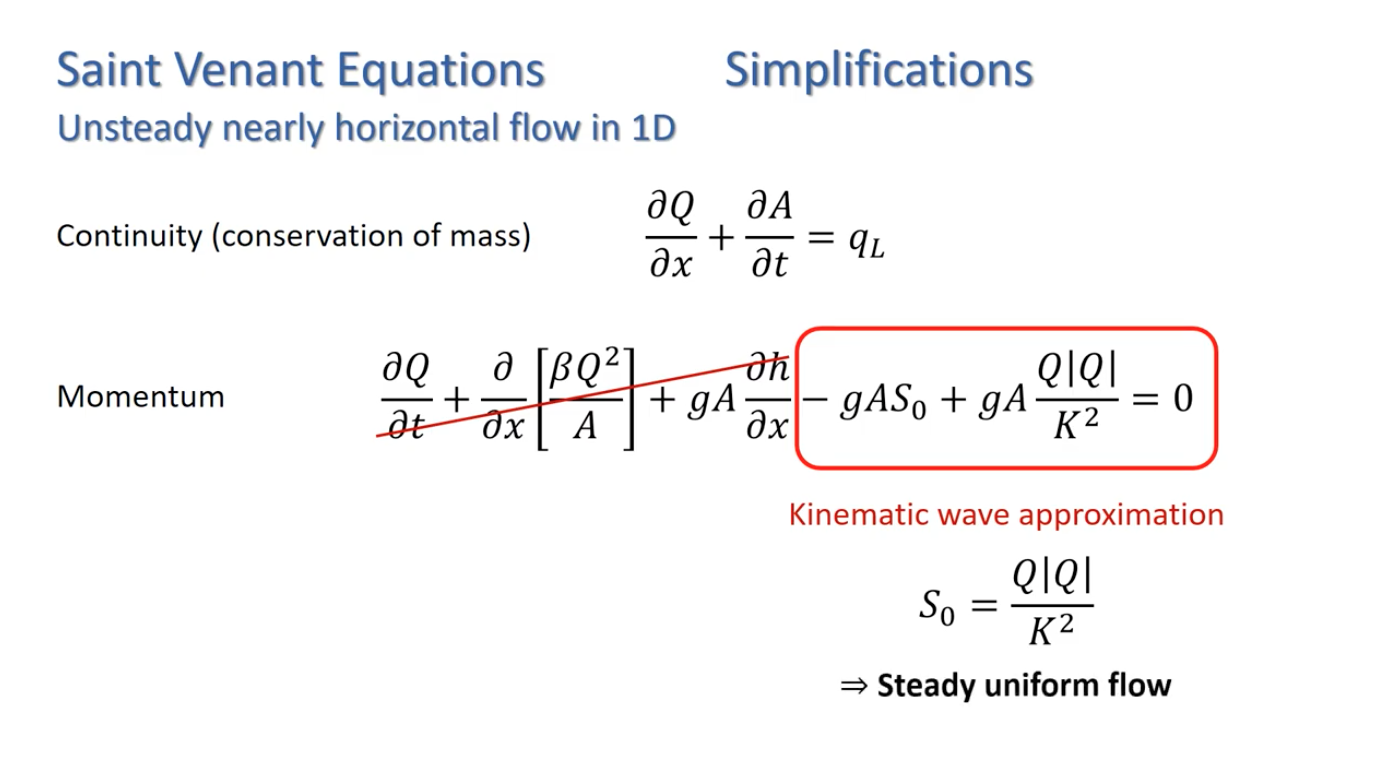